# kNN

This notebook is for practical implementations of kNN. For the relevant theory, please refer to the Supervised Learning workbook (link to be added).

## Algorithm

## Implementation

In [124]:
def euclidean_dist(arr1, arr2):
    dist = 0
    for x1, x2 in zip(arr1, arr2):
        dist += (x1-x2)**2
    return dist**0.5



class kNN:
    def __init__(self, k, metric, algorithm = 'brute'):
        self.k = k
        self.metric = metric
        self.algorithm = algorithm
    
    def fit(self, X, y):
        
        # depending on the type of algorithm that you want to go for, the fit function
        # should generate the necessary data structures!
        
        if self.algorithm == 'brute':
            self.X = X
            self.y = y
    
    def predict(self, X):
        # maybe the output should also be a numpy array? Not a list?
        
        y_pred = []
        for x_test in X:
            dist = [self.metric(x_test, x_train) for x_train in self.X] 
            dist, y = zip(*sorted(zip(dist, self.y)))
            y = y[:self.k]
            y_pred.append(max(y,key=y.count))
        return y_pred

## Example

- The fit function normally does some training, but in the case of a simple implementation kNN, this has the purpose of simply storing the data. For more info click [here](https://stats.stackexchange.com/questions/349842/why-do-we-need-to-fit-a-k-nearest-neighbors-classifier)
- make sure to use the log(nsamples) to estimate which k to use
- add stuff about evaluating the algorithm, error, cross validation, plot of the voronoi cells ?

In [7]:
# relevant modules

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# util functions
def plot_classes(X, y):
    for i in np.unique(y):
        plt.plot(X[y == i, 0], X[y == i, 1], '.')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
def plot_contour(X, y, fitted_model, *xlim):
    xlim = [np.linspace(*xlim_) if isinstance(xlim_, tuple) else np.linspace(min(xlim_), max(xlim_), len(xlim_)) for xlim_ in xlim]
    X_grid = [grid.reshape(-1,1) for grid in np.meshgrid(*xlim)]
    X_grid = np.concatenate(tuple(X_grid), axis = 1)    
    y_pred = np.array(fitted_model.predict(X_grid))
    plt.contour(*xlim, y_pred.reshape(*[len(xlim_) for xlim_ in xlim]))
    

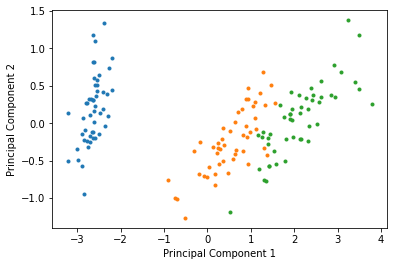

In [148]:
# load the dataset
X,y = load_iris(return_X_y = True)

# reduce dataset size to have 2 dimensions only
model = PCA(2)
X = model.fit_transform(X)

# visualize plot
plot_classes(X, y)

((-4, 4, 50), (-1.5, 1.5, 50))
(2500, 2)


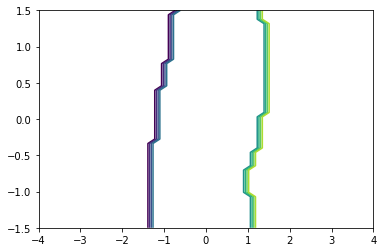

In [168]:
"""
x1_ = np.linspace(-4,4, 50)
x2_ = np.linspace(-1.5, 1.5, 50)
x1, x2 = np.meshgrid(x1_, x2_)
x1 = x1.reshape(-1,1)
x2 = x2.reshape(-1,1)
X_grid = np.concatenate((x1, x2), axis = 1)

model = kNN(30, euclidean_dist)

model.fit(X, y)
print('model fitted')
y_pred = np.array(model.predict(X_grid))
print('model predicted')
plt.contourf(x1_, x2_, y_pred.reshape(-50,50))
plot_classes(X, y)"""

model = kNN(30, euclidean_dist)

model.fit(X, y)

plot_contour(X, y, model, (-4,4, 50), (-1.5, 1.5, 50))

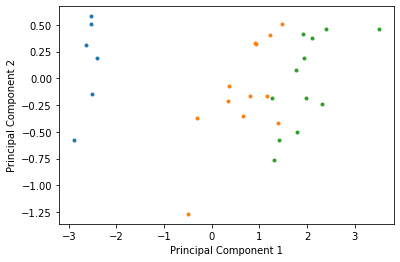

In [73]:
model = kNN(1, euclidean_dist)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_classes(X_test, y_pred)

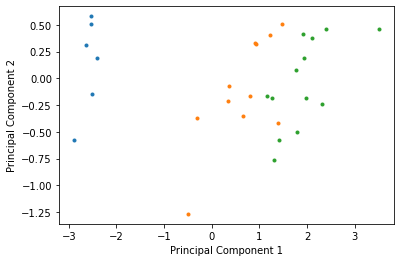

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# Experiments

An attempt to plot the bias vs. variance tradeoff plot (generalisation error)

In [27]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
from time import time
from mlxtend.evaluate import bias_variance_decomp


class FaissKNeighbors:
    def __init__(self, k=3):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y
        return self

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [29]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split


n_samples = 5000
test_size = 0.2


# improve on this, I don't understand why you get the zigzag line
def generate_k_range(n_points, n_samples, n_fine = 15):
    k = list(range(1, n_fine)) + list(np.linspace(n_fine, n_samples - n_fine , n_points, dtype = int)) + sorted(list(range(n_samples - 1, n_samples - n_fine, -1)))
    return k


k = generate_k_range(100, n_samples, n_fine = 30)
test_error = []
train_error = []
bias = []
var = []
loss = []
for k_ in k:
    print(f'Currently at k={k_}')
    
    kNN = FaissKNeighbors(k_)
    X, y = make_circles(n_samples,factor = 0.5, noise = 0.1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        kNN, X_train, y_train, X_test, y_test, 
        loss='0-1_loss')
    loss.append(avg_expected_loss)
    bias.append(avg_bias)
    var.append(avg_var)
    if k_ == 30:
        break
    #kNN.fit(X_train,X_test)
    #y_hat = kNN.predict(X)
    #train_error.append((len(y_hat) - sum(y_hat == y))/len(y_hat))
    #X_test, y_test = make_circles(test_size,factor = 0.5, noise = 0.1)
    #y_hat = kNN.predict(X_test)
    #test_error.append((len(y_hat) - sum(y_hat == y_test))/len(y_hat))
    
    # given a point, find bias, variance and 
#plot_classes(X,y)




Currently at k=1
Currently at k=2
Currently at k=3
Currently at k=4
Currently at k=5
Currently at k=6
Currently at k=7
Currently at k=8
Currently at k=9
Currently at k=10
Currently at k=11
Currently at k=12
Currently at k=13
Currently at k=14
Currently at k=15
Currently at k=16
Currently at k=17
Currently at k=18
Currently at k=19
Currently at k=20
Currently at k=21
Currently at k=22
Currently at k=23
Currently at k=24
Currently at k=25
Currently at k=26
Currently at k=27
Currently at k=28
Currently at k=29
Currently at k=30


TypeError: in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'

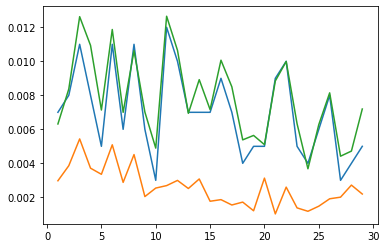

In [31]:

plt.plot(k[:29], bias)
plt.plot(k[:29], var)
plt.plot(k[:29], loss)



In [ ]:
def generate_circular_data(n_samples, noise):
    
    


In [48]:
def measure_gen_error(X, y, k_range, n_repeats = 100, test_size = 0.2):
    global_errors = []
    tot_time = 0
    failed_k = set()
    for k_ in k_range:
        start = time()
        print(f'We are at k={k_}')
        tot_err = 0
        for run in range(n_repeats):
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

            kNN_model = FaissKNeighbors(k_)
            kNN_model.fit(X_train, y_train)
            
            
            
            
            #X_test,y_test = make_circles(1000, noise = 0.1)
            
            # calculate y_hat
            try:
                y_hat = kNN_model.predict(
                    X_test,
                )
            except Exception as e:
                print(k_)
                print(e)
                failed_k.add(k_)
            
            

            
            correctness_index = [y_hat_ == y_test_ for y_hat_, y_test_ in zip(y_hat, y_test)]
     
            tot_err += (len(correctness_index) - sum(correctness_index))/len(correctness_index)

        global_errors.append(tot_err/100)
        time_taken = time()-start
        tot_time += time_taken
        print(f'Time taken for k={k_} is {time_taken}. Estimated time remaining is {(tot_time/k_) * (49 - k_)}')
        
        # average the generalisation error
    k = [k_ for k_ in k_range if k_ not in failed_k]
    return k, global_errors

In [49]:
k = generate_k_range(100, n_samples, n_fine = 30)

n_samples = 5000
X, y = make_circles(n_samples,factor = 0.5, noise = 0.1)
k, errors = measure_gen_error(X, y, k)

We are at k=1
Time taken for k=1 is 2.538336992263794. Estimated time remaining is 121.84017562866211
We are at k=2
Time taken for k=2 is 2.658068895339966. Estimated time remaining is 122.11553835868835
We are at k=3
Time taken for k=3 is 2.981297016143799. Estimated time remaining is 125.39144452412924
We are at k=4
Time taken for k=4 is 3.0033371448516846. Estimated time remaining is 125.78670054674149
We are at k=5
Time taken for k=5 is 4.242500066757202. Estimated time remaining is 135.7271530151367
We are at k=6
Time taken for k=6 is 2.6218748092651367. Estimated time remaining is 129.32547362645468
We are at k=7
Time taken for k=7 is 2.4982457160949707. Estimated time remaining is 123.26196384429932
We are at k=8
Time taken for k=8 is 3.138669013977051. Estimated time remaining is 121.37193948030472
We are at k=9
Time taken for k=9 is 4.237381935119629. Estimated time remaining is 124.08760706583658
We are at k=10
Time taken for k=10 is 6.072595834732056. Estimated time remainin

30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
30
in method 'IndexFlat_search', argum

129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
129
in method 'IndexFlat_

179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
179
in method 'IndexFlat_

229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
229
in method 'IndexFlat_

279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
279
in method 'IndexFlat_

329
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
329
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
329
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
329
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
329
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
329
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
329
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
329
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=329 is 0.9115540981292725. Estimated time remaining is -105.65636269589687
We are at k=379
379
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
379
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
379
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
379
in method 'IndexFlat_search', argument 4 of type 'faiss::Index:

429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
429
in method 'IndexFlat_

479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
479
in method 'IndexFlat_

528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
528
in method 'IndexFlat_

578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
578
in method 'IndexFlat_

628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
628
in method 'IndexFlat_

678
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
678
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
678
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
678
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=678 is 0.8497462272644043. Estimated time remaining is -120.21721455164716
We are at k=728
728
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
728
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
728
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
728
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
728
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
728
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
728
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
728
in method 'IndexFlat_search', argument 4 of type 'faiss::Index:

778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
778
in method 'IndexFlat_

828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
828
in method 'IndexFlat_

878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
878
in method 'IndexFlat_

928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
928
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=928 is 0.9432897567749023. Estimated time remaining is -126.62231244172514
We are at k=978
978
in method 'IndexFlat_search', argument 4 of type 'faiss::Index:

1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1027
in meth

1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1077
in meth

1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1127
in meth

1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1177
in meth

1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1227
in meth

1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1277
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken f

1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1377
in meth

1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1427
in meth

1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1477
in meth

1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1526
in meth

1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1576
in meth

1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1626
in meth

1676
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1676
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1676
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1676
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1676
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1676
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=1676 is 0.894085168838501. Estimated time remaining is -141.05285028185082
We are at k=1726
1726
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1726
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1726
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1726
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1726
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1726
in method 'IndexFlat_search', argument 4 of type '

1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1776
in meth

1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1826
in meth

1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1876
in meth

1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1926
in meth

1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
1976
in meth

2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2075
in meth

2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2125
in meth

2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2175
in meth

2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2225
in meth

2275
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2275
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2275
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2275
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2275
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=2275 is 0.8039250373840332. Estimated time remaining is -151.65848011603723
We are at k=2325
2325
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2325
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2325
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2325
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2325
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2325
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2325
in method 'IndexFlat_search', argument 4 of type 

2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2375
in meth

2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2425
in meth

2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2475
in meth

2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2524
in meth

2574
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2574
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=2574 is 1.464367151260376. Estimated time remaining is -157.64371774969123
We are at k=2624
2624
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2624
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2624
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2624
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2624
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2624
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2624
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2624
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2624
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2624
in method 'IndexFlat_search', argument 4 of type '

2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2674
in meth

2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2724
in meth

in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2774
in method 'I

2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2824
in meth

2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2874
in meth

2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
2974
in meth

3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3023
in meth

3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3073
in meth

3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3123
in meth

3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3173
in meth

3223
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=3223 is 2.1236212253570557. Estimated time remaining is -172.53704391530385
We are at k=3273
3273
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3273
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3273
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3273
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3273
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3273
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3273
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3273
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3273
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3273
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3273
in method 'IndexFlat_search', argument 4 of type 

3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3323
in meth

3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3373
in meth

3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3423
in meth

3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3473
in meth

3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3522
in meth

3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3572
in meth

3622
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3622
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3622
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3622
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3622
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3622
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3622
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3622
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3622
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3622
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=3622 is 0.7771127223968506. Estimated time remaining is -182.05381980902052
We are at k=3672
3672
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3672
in method 'IndexFlat_search', argument 4 of type 

3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3722
in meth

3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3772
in meth

3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3822
in meth

3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3872
in meth

3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3922
in meth

3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
3972
in meth

4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4021
in meth

4071
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4071
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4071
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=4071 is 0.7453992366790771. Estimated time remaining is -190.69782137454976
We are at k=4121
4121
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4121
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4121
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4121
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4121
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4121
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4121
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4121
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4121
in method 'IndexFlat_search', argument 4 of type 

4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4171
in meth

4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4221
in meth

in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4271
in method 'I

4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4321
in meth

4371
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=4371 is 1.0323247909545898. Estimated time remaining is -196.51796256625877
We are at k=4421
4421
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4421
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4421
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4421
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4421
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4421
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4421
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4421
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4421
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4421
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4421
in method 'IndexFlat_search', argument 4 of type 

4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4471
in meth

4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4520
in meth

4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4570
in meth

4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4620
in meth

4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4670
in meth

4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4720
in meth

4770
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4770
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
Time taken for k=4770 is 1.2379701137542725. Estimated time remaining is -207.79926397415576
We are at k=4820
4820
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4820
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4820
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4820
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4820
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4820
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4820
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4820
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4820
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4820
in method 'IndexFlat_search', argument 4 of type 

4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4870
in meth

4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4920
in meth

4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'
4970
in meth

In [51]:
errors

[0.011969999999999996,
 0.011310000000000004,
 0.009150000000000007,
 0.009430000000000008,
 0.008920000000000006,
 0.008870000000000006,
 0.008710000000000006,
 0.008190000000000006,
 0.008180000000000007,
 0.007870000000000005,
 0.007760000000000006,
 0.007750000000000006,
 0.008350000000000007,
 0.008010000000000007,
 0.007780000000000006,
 0.008190000000000006,
 0.0078100000000000044,
 0.008070000000000004,
 0.008170000000000005,
 0.007690000000000006,
 0.007630000000000006,
 0.008130000000000005,
 0.007650000000000006,
 0.007920000000000005,
 0.007430000000000004,
 0.007240000000000005,
 0.007390000000000005,
 0.007000000000000005,
 0.007850000000000006,
 0.49625,
 0.4974099999999999,
 0.4990200000000001,
 0.5006100000000003,
 0.49905,
 0.4992200000000001,
 0.5007900000000002,
 0.5004400000000001,
 0.49788,
 0.5005000000000001,
 0.5033300000000002,
 0.5010400000000002,
 0.49830999999999986,
 0.49912000000000006,
 0.5031800000000003,
 0.5008,
 0.5002400000000002,
 0.500649999999999

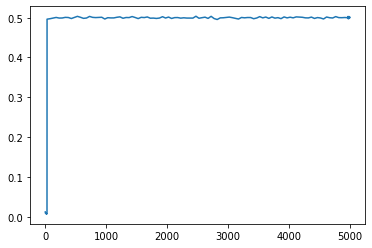

In [52]:
plt.plot(generate_k_range(100, n_samples, n_fine = 30), errors) # need to extend this anlysis but for k = infinity. Why does faiss fail after 30?

# Useful Links

https://stats.stackexchange.com/questions/485884/bias-and-variance-in-knn-and-decision-trees
https://stats.stackexchange.com/questions/107870/does-k-nn-with-k-1-always-implies-overfitting
https://stackoverflow.com/questions/5751114/nearest-neighbors-in-high-dimensional-data
https://stackoverflow.com/questions/33508247/how-to-handle-duplicate-data-points-in-k-nearest-neighbor-algorithm